### Objectifs de ce notebook :
>Utilisation des données du site https://data.cityofchicago.org/ sur la criminalité ainsi que des données  socio-économiques du ministère de la Santé de Chicago https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2.
- Extraction des features
- Label ou taget (variables à prédire) : type de crime à prédire
- Implémentation d'algorithme de machine learning sur l'annés 2012 et application sur l'année 2013
- Visualisation des résultats

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import numpy as np
import pandas as pd
import datetime as dthttp://localhost:8888/notebooks/Documents/crimes_chigaco/notebooks/old/Classification_crime.ipynb
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
category = LabelEncoder()


In [3]:
Path_Socio = "/home/ml/Documents/crimes_chigaco/data/raw/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv"
Path_Crime = "/home/ml/Documents/crimes_chigaco/data/raw/Crimes_-_2001_to_present.csv"

In [4]:
df_Socio = pd.read_csv(Path_Socio)
df_Crime = pd.read_csv(Path_Crime, sep=';', parse_dates=['Date'])

In [5]:
def set_param():
    
    # setup parameters for xgboost
    param = {}
    param['objective'] = 'multi:softmax'
    param['eta'] = 0.1
    param['silent'] = 0
    param['nthread'] = 4
    param['num_class'] = num_class
    param['eval_metric'] = 'mlogloss'
    param[' n_estimators'] = 300

    # Model complexity
    param['max_depth'] = 10 #set to 8
    param['min_child_weight'] = 1
    param['gamma'] = 0 
    param['reg_alfa'] = 0.05

    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8 #set to 1

    # Imbalanced data
    param['max_delta_step'] = 1
    
    return param

In [6]:
def rename_columns_socio():
    """
    
    """
    return {
'Community Area Number':'community_area_number',
'COMMUNITY AREA NAME':'community_area_name', 
'PERCENT OF HOUSING CROWDED':'pct_housing_crowded', 
'PERCENT HOUSEHOLDS BELOW POVERTY':'pct_households_below_poverty', 
'PERCENT AGED 16+ UNEMPLOYED':'pct_age16_unemployed',
'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA':'pct_age25_no_highschool',
'PERCENT AGED UNDER 18 OR OVER 64': 'pct_not_working_age',
'per_capita_income':'per_capita_income',
'HARDSHIP INDEX' : 'hardship_index'}

def rename_columns_crimes():
    """
    
    """
    return {
        'ID': 'id',
        'Case Number': 'cas_number', 
        'Date':'date',
        'Block':'block', 
        'IUCR':'iucr', 
        'Primary Type':'primary_type',
        'Description':'description', 
        'Location Description':'location_description', 
        'Arrest':'arrest', 
        'Domestic':'domestic', 
        'Beat':'beat',
        'District':'district', 
        'Ward':'ward', 
        'Community Area': 'community_area_number', 
        'FBI Code':'fbi_code', 
        'X Coordinate':'x_coordinate',
        'Y Coordinate':'y_coordinate', 
        'Year':'year', 
        'Updated On':'updated_on', 
        'Latitude':'latitude', 
        'Longitude':'longitude',
        'Location':'location'   
    }

df_Socio.rename(columns=rename_columns_socio(), inplace=True)
df_Crime.rename(columns=rename_columns_crimes(), inplace=True)

In [7]:
df_Crime_2012 = df_Crime[df_Crime['year']==2012]

In [8]:
## list of crime to predict
list_of_crimes = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY','ASSAULT']
list_to_drop = ['id','location','cas_number','date','block','iucr','primary_type','updated_on',\
                                         'description','location_description','arrest','domestic','beat','district','ward','community_area_number','fbi_code']

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

 

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.figure(figsize=(15, 15))

In [41]:
def extract_feature(year, df_C, df_S, list_of_crimes, list_to_drop):
    """
    this function extract features for machine learning algorithm
    """
    df = df_Crime[df_Crime['year']==year]
    df = df[df.primary_type.isin(list_of_crimes)]
    df['month']=df_Crime_2012['date'].dt.month
    df['day']=df_Crime_2012['date'].dt.day
    df['hours']=df_Crime['date'].dt.hour
    df['minutes']=df_Crime_2012['date'].dt.minute
    df['dayofweek']= df_Crime_2012['date'].apply(lambda x: dt.datetime.strftime(x, '%A'))
    df['XY']=df.x_coordinate*df.y_coordinate 
    
    df['Category'] = category.fit_transform(df.primary_type)
    df = df[df.primary_type.isin(list_of_crimes)]
    df = pd.get_dummies(df, columns = ['dayofweek'])
    df_crime_socio = pd.merge(df,df_S,on = 'community_area_number', how ='left')
    df_crime_socio_ml=pd.get_dummies(df_crime_socio, columns=['community_area_name'])
    del df_crime_socio, df
    return df_crime_socio_ml.drop(list_to_drop, axis=1), list(category.classes_)

In [42]:
df_ml, class_names=extract_feature(2012, df_Crime, df_Socio, list_of_crimes, list_to_drop)

In [31]:
df_ml.Category.value_counts()

5    75459
1    59135
3    35854
4    35488
2    22843
0    19898
Name: Category, dtype: int64

In [38]:
classe_name

['ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'THEFT']

In [12]:
df_ml.sample(5)

,x_coordinate,y_coordinate,year,latitude,longitude,month,day,hours,minutes,XY,...,community_area_name_Washington Height,community_area_name_Washington Park,community_area_name_West Elsdon,community_area_name_West Englewood,community_area_name_West Garfield Park,community_area_name_West Lawn,community_area_name_West Pullman,community_area_name_West Ridge,community_area_name_West Town,community_area_name_Woodlawn
161402,1174599.0,1831706.0,2012,41.693590,-87.636374,8,17,8,0,2.151520e+12,...,0,0,0,0,0,0,0,0,0,0
148368,1172734.0,1839039.0,2012,41.713754,-87.642987,7,5,23,15,2.156704e+12,...,1,0,0,0,0,0,0,0,0,0
45681,1152801.0,1933422.0,2012,41.973168,-87.713495,4,10,13,35,2.228851e+12,...,0,0,0,0,0,0,0,0,0,0
115495,1150196.0,1859643.0,2012,41.770761,-87.724997,1,25,12,30,2.138954e+12,...,0,0,0,0,0,1,0,0,0,0
73414,1166412.0,1933323.0,2012,41.972615,-87.663448,5,22,14,30,2.255051e+12,...,0,0,0,0,0,0,0,0,0,0


In [13]:
list(df_Socio.columns)

['community_area_number',
 'community_area_name',
 'pct_housing_crowded',
 'pct_households_below_poverty',
 'pct_age16_unemployed',
 'pct_age25_no_highschool',
 'pct_not_working_age',
 'PER CAPITA INCOME ',
 'hardship_index']

### Implémentation d'algorithme de machine learning

In [14]:
feature_cols = [x for x in df_ml if x!='Category']
X = df_ml[feature_cols]
y = df_ml['Category']
X_train, x_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=42)

In [27]:
X.shape

(248677, 102)

In [28]:
y.shape

(248677,)

In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
num_class = len(y.unique())
param = set_param()
watchlist = [(dtrain,'train'), (dtest, 'eval')]
num_round = 30

# Train XGBoost    
bst = xgb.train(param, dtrain, num_round, watchlist);


[14:33:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=10
[14:33:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1410 extra nodes, 0 pruned nodes, max_depth=10
[14:33:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1164 extra nodes, 0 pruned nodes, max_depth=10
[14:33:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1200 extra nodes, 0 pruned nodes, max_depth=10
[14:33:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1224 extra nodes, 0 pruned nodes, max_depth=10
[14:33:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1108 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-mlogloss:1.75445	eval-mlogloss:1.75868
[14:33:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 0 pruned nodes, max_depth=10
[14:34:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 

[14:35:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 0 pruned nodes, max_depth=10
[14:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=10
[14:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1278 extra nodes, 0 pruned nodes, max_depth=10
[14:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1440 extra nodes, 0 pruned nodes, max_depth=10
[10]	train-mlogloss:1.51778	eval-mlogloss:1.56223
[14:35:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=10
[14:35:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1284 extra nodes, 0 pruned nodes, max_depth=10
[14:35:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1204 extra nodes, 0 pruned nodes, max_depth=10
[14:35:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end,

[14:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1210 extra nodes, 0 pruned nodes, max_depth=10
[14:37:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1288 extra nodes, 0 pruned nodes, max_depth=10
[20]	train-mlogloss:1.41345	eval-mlogloss:1.49285
[14:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1058 extra nodes, 0 pruned nodes, max_depth=10
[14:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1200 extra nodes, 0 pruned nodes, max_depth=10
[14:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1136 extra nodes, 0 pruned nodes, max_depth=10
[14:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 998 extra nodes, 0 pruned nodes, max_depth=10
[14:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1446 extra nodes, 0 pruned nodes, max_depth=10
[14:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end,

In [16]:
preds = bst.predict(dtest)

In [17]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds, average='macro'))

0.3736521063254337


In [18]:
print(accuracy_score(y_test, preds))

0.43082140367808697


In [19]:
from sklearn.metrics import classification_report

In [20]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5']
print(classification_report(y_test, preds, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.22      0.00      0.00      6030
    class 1       0.35      0.50      0.42     17567
    class 2       0.38      0.04      0.07      6870
    class 3       0.33      0.04      0.07     10805
    class 4       0.48      0.54      0.51     10705
    class 5       0.47      0.74      0.58     22627

avg / total       0.40      0.43      0.36     74604



Confusion matrix, without normalization
[[    8  2657    48    89   966  2262]
 [   19  8811   107   247  2824  5559]
 [    2  1798   270   154   380  4266]
 [    3  4031   104   410   972  5285]
 [    1  3296    23    46  5785  1554]
 [    3  4229   153   300  1085 16857]]
Normalized confusion matrix
[[1.33e-03 4.41e-01 7.96e-03 1.48e-02 1.60e-01 3.75e-01]
 [1.08e-03 5.02e-01 6.09e-03 1.41e-02 1.61e-01 3.16e-01]
 [2.91e-04 2.62e-01 3.93e-02 2.24e-02 5.53e-02 6.21e-01]
 [2.78e-04 3.73e-01 9.63e-03 3.79e-02 9.00e-02 4.89e-01]
 [9.34e-05 3.08e-01 2.15e-03 4.30e-03 5.40e-01 1.45e-01]
 [1.33e-04 1.87e-01 6.76e-03 1.33e-02 4.80e-02 7.45e-01]]


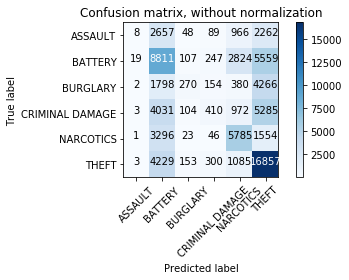

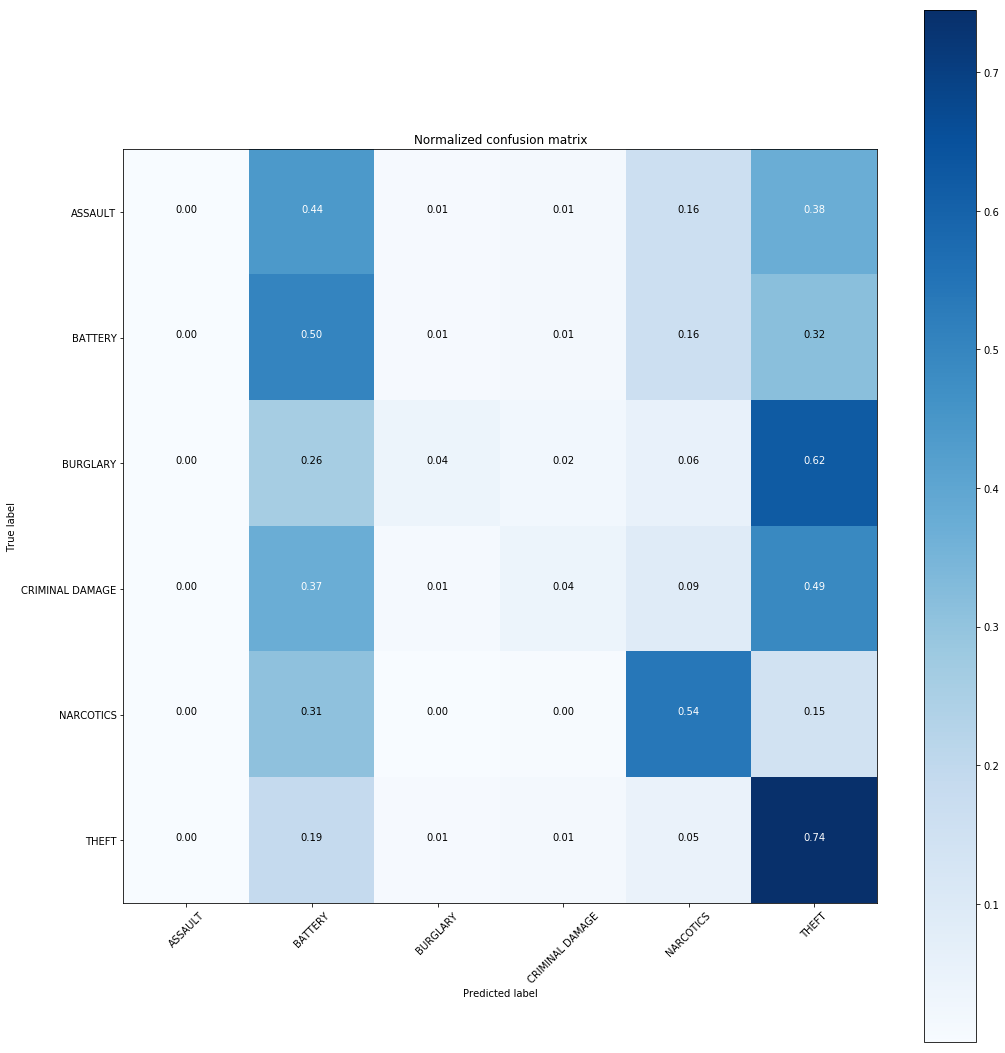

<Figure size 1080x1080 with 0 Axes>

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figsize=(10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figsize=(10, 10)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')